# MLP Models

Ok so let's bring out the big guns and try on the simple dataset

In [21]:
%pip install tensorflow keras

1553.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [22]:
import tensorflow as tf
from tensorflow import keras
import pickle, os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sys.path.append("..")
from utils import plot_mat_comp, flatten_triang, unflatten_triang, flatten_triang_batch, unflatten_triang_batch, perform_calculation, density_from_fock, reverse_mat_permutation

Test and train data is generated in overlap_to_fock_first_steps and also used here!

In [23]:
with open('models/test_data.pkl', 'rb') as f:
    test = pickle.load(f)
with open('models/train_data.pkl', 'rb') as f:
    train = pickle.load(f)
train_X = np.array([overlap for _, overlap, _, _ in train])
train_y = np.array([fock for fock, _, _, _ in train])
test_X = np.array([overlap for _, overlap, _, _ in test])
test_y = np.array([fock for fock, _, _, _ in test])
train_files = np.array([file for _, _, file, _ in train])
test_files = np.array([file for _, _, file, _ in test])
train_densities = np.array([density for _, _, _, density in train])
test_densities = np.array([density for _, _, _, density in test])
mat_dim = train_X[0].shape[0]
mat_dim


49

# Data Aug

In [24]:
def data_aug(train_X, train_y, test_X, test_y, train_files, test_files,  multiple=5): 
    from scf_guess_tools import load, Backend
    train_X_aug, train_y_aug = [], []
    test_X_aug, test_y_aug = [], []
    nr_atoms = int(open(train_files[0]).readlines()[0].split()[0]) # assume same number of atoms in all files
    for X, y, file in zip(train_X,  train_y,  train_files):
        mol = load(file, Backend.PY).native
        ao = mol.ao_labels()
        train_X_aug.append(X) # original
        train_y_aug.append(y) # original
        for _ in range(1, multiple): 
            # augment with random permutation
            perm = np.random.permutation(nr_atoms)
            train_X_aug.append(reverse_mat_permutation(X, ao, perm))
            train_y_aug.append(reverse_mat_permutation(y, ao, perm))

    for X, y, file in zip(test_X,  test_y,  test_files):
        mol = load(file, Backend.PY).native
        ao = mol.ao_labels()
        test_X_aug.append(X) # original
        test_y_aug.append(y) # original
        for _ in range(1, multiple): 
            # augment with random permutation
            perm = np.random.permutation(nr_atoms)
            test_X_aug.append(reverse_mat_permutation(X, ao, perm))
            test_y_aug.append(reverse_mat_permutation(y, ao, perm))
    train_X_aug = np.array(train_X_aug)
    train_y_aug = np.array(train_y_aug)
    test_X_aug = np.array(test_X_aug)
    test_y_aug = np.array(test_y_aug)
     
    return train_X_aug, train_y_aug, test_X_aug, test_y_aug

In [25]:
data_Aug = True
if data_Aug: 
    print("Data Augmentation")
    train_X, train_y, test_X, test_y = data_aug(train_X, train_y, test_X, test_y, train_files, test_files)

Data Augmentation


In [26]:
def summary(X): 
    print(f"shape: {X.shape}")
    print(f"dtype: {X.dtype}")
    print(f"min: {np.min(X)}")
    print(f"max: {np.max(X)}")
    print(f"mean: {np.mean(X)}")
    print(f"std: {np.std(X)}")
    print(f"median: {np.median(X)}")
    print(f"10th percentile: {np.percentile(X, 10)}")
    print(f"90th percentile: {np.percentile(X, 90)}")

In [27]:
train_X_flattened = flatten_triang_batch(train_X)
train_y_flattened = flatten_triang_batch(train_y)
test_X_flattened = flatten_triang_batch(test_X)
test_y_flattened = flatten_triang_batch(test_y)
summary(train_X_flattened)

shape: (2030, 1225)
dtype: float64
min: -0.4781431157238504
max: 1.0000000000000002
mean: 0.048012666387895954
std: 0.21050674256765434
median: 5.214819106295551e-07
10th percentile: -0.022566803988282633
90th percentile: 0.10159268928878583


In [28]:
# scale data
scalerX = StandardScaler()
scalerY = StandardScaler()
train_X_scaled_flattened = scalerX.fit_transform(train_X_flattened)
train_y_scaled_flattened = scalerY.fit_transform(train_y_flattened)
test_X_scaled_flattened = scalerX.transform(test_X_flattened)
test_y_scaled_flattened = scalerY.transform(test_y_flattened)

summary(train_X_scaled_flattened)

shape: (2030, 1225)
dtype: float64
min: -29.297888191087427
max: 30.154925081615886
mean: 2.7858818432335283e-18
std: 0.9797958971132712
median: -0.05257588680760206
10th percentile: -0.48097850105824697
90th percentile: 0.5052485489364832


Now we only take upper triangular matrix!

In [29]:
# for now set a seed
tf.random.set_seed(42)

flattened_dim = train_X_scaled_flattened.shape[1]
inputs = tf.keras.Input(shape=(flattened_dim,))
x = tf.keras.layers.Dense(512, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(flattened_dim)(x)

basic_model = tf.keras.Model(inputs=inputs, outputs=outputs)
basic_model.compile(optimizer='adam', loss="mae", metrics=["mse", 'mae'])
# basic_model.summary()


2025-04-14 13:37:34.265603: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
basic_history = basic_model.fit(train_X_scaled_flattened, train_y_scaled_flattened, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
plt.plot(basic_history.history['loss'], label='train')
plt.plot(basic_history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6878 - mae: 0.6878 - mse: 1.2370 - val_loss: 0.5298 - val_mae: 0.5298 - val_mse: 1.0463
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5295 - mae: 0.5295 - mse: 1.0364 - val_loss: 0.4867 - val_mae: 0.4867 - val_mse: 1.0185
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4695 - mae: 0.4695 - mse: 0.9900 - val_loss: 0.4670 - val_mae: 0.4670 - val_mse: 1.0093
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4524 - mae: 0.4524 - mse: 0.9840 - val_loss: 0.4483 - val_mae: 0.4483 - val_mse: 0.9896
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4440 - mae: 0.4440 - mse: 0.9838 - val_loss: 0.4360 - val_mae: 0.4360 - val_mse: 0.9769
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4361 - mae: 0.4361 - mse: 0.9817 - val_loss: 0.4293 - val_mae: 0.4293 - val_mse: 0.9739
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4321 - mae: 0.4321 - mse: 0.9792 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


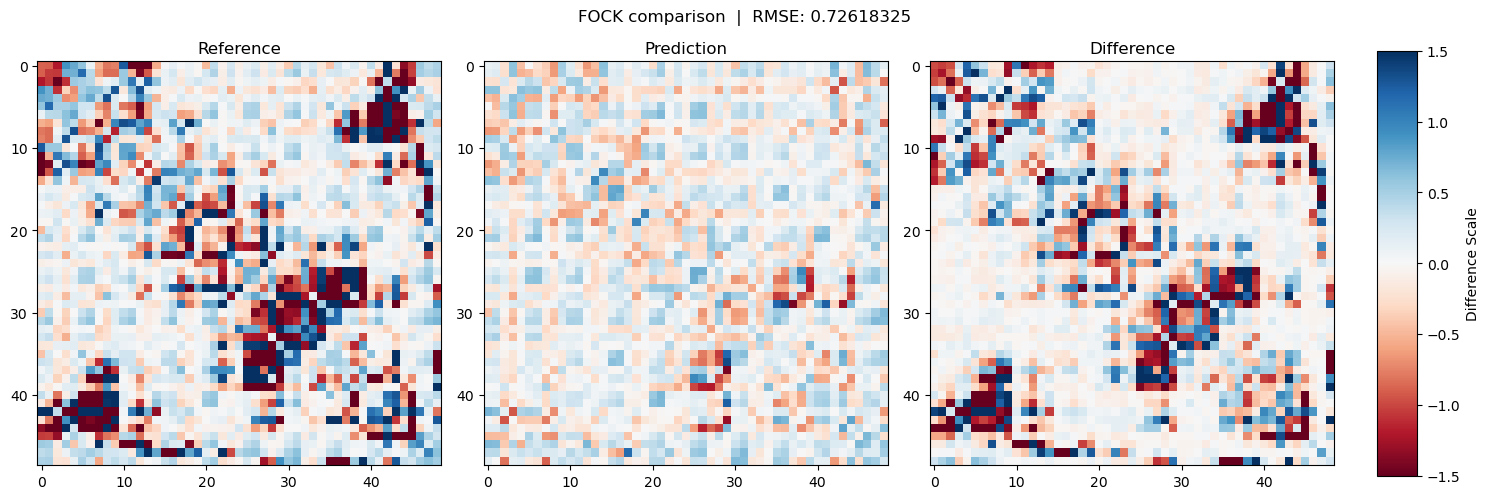

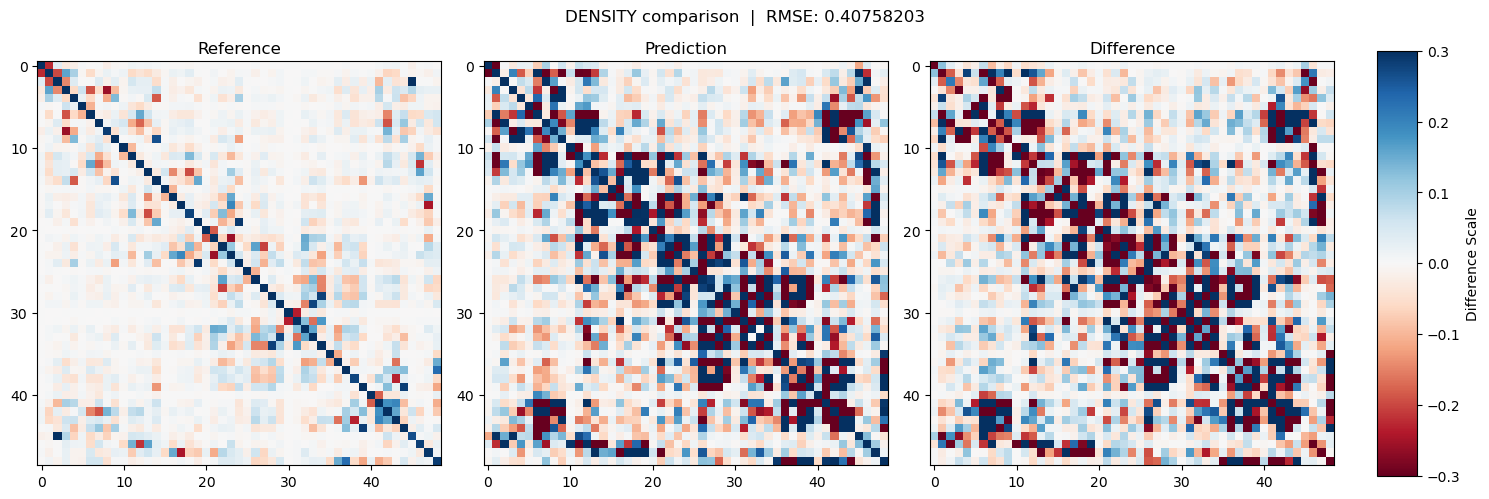

converged SCF energy = -446.859372597777
{'cycles': 20, 'conv': True, 'summary': {'nuc': np.float64(415.91137850419045), 'e1': np.float64(-1434.6727560597067), 'coul': np.float64(631.533024812993), 'exc': np.float64(-59.63101985525416)}}


In [69]:
def random_sample(model = basic_model, flat_input=True):
    random_test_sample = np.random.randint(0, len(test_X_scaled_flattened))
    test_file = test_files[random_test_sample]
    test_ref = test_y_scaled_flattened[random_test_sample]
    if flat_input:
        test_pred = model.predict(test_X_scaled_flattened[random_test_sample].reshape(1, -1))
    else: 
        sample = unflatten_triang(test_X_scaled_flattened[random_test_sample], mat_dim) 
        test_pred = model.predict(sample.reshape(1, mat_dim, mat_dim))
    plot_mat_comp(test_ref, test_pred[0], reshape=49, title="FOCK comparison")
    # rescale prediciton
    test_pred_rescaled = scalerY.inverse_transform(test_pred.reshape(1, -1)).reshape(-1)
    test_pred_rescaled = unflatten_triang(test_pred_rescaled, 49)
    density_prediction = density_from_fock(test_pred_rescaled, test_X[random_test_sample], 32)
    plot_mat_comp(test_densities[random_test_sample], density_prediction, title="DENSITY comparison", vmax=0.3)
    summary = perform_calculation(test_file, 2*density_prediction, "sto-3g", "dft", "b3lypg")
    print(summary)

random_sample()


In [36]:
flattened_dim = train_X_scaled_flattened.shape[1]
inputs = tf.keras.Input(shape=(flattened_dim,))
x = tf.keras.layers.Dense(512, activation='gelu')(inputs)
for _ in range(4):
    x = tf.keras.layers.Dense(512, activation='gelu')(x)
# x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation='gelu')(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(flattened_dim)(x)

basic_model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
basic_model_2.compile(optimizer='adam', loss="mae", metrics=["mse", 'mae'])

Epoch 1/150


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5736 - mae: 0.5736 - mse: 1.0005 - val_loss: 0.5302 - val_mae: 0.5302 - val_mse: 0.9433
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5429 - mae: 0.5429 - mse: 1.0046 - val_loss: 0.5165 - val_mae: 0.5165 - val_mse: 0.9413
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5297 - mae: 0.5297 - mse: 0.9908 - val_loss: 0.5073 - val_mae: 0.5073 - val_mse: 0.9150
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5179 - mae: 0.5179 - mse: 0.9621 - val_loss: 0.4983 - val_mae: 0.4983 - val_mse: 0.9014
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5080 - mae: 0.5080 - mse: 0.9371 - val_loss: 0.4885 - val_mae: 0.4885 - val_mse: 0.8782
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4991 - mae: 0.4991 - mse: 0.9119 - val_loss: 0.4815 - val_mae: 0.4815 - val_mse: 0.8642
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4911 - mae: 0.4911 - mse: 0.8924 - val_loss: 0.477

Text(0.5, 1.0, 'Model loss')

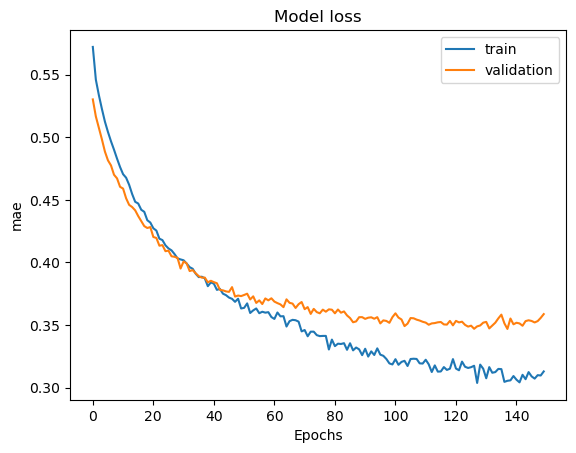

In [37]:
basic_history_2 = basic_model_2.fit(train_X_scaled_flattened, train_y_scaled_flattened, epochs=150, batch_size=32, validation_split=0.2, verbose=1)
plt.plot(basic_history_2.history['loss'], label='train')
plt.plot(basic_history_2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


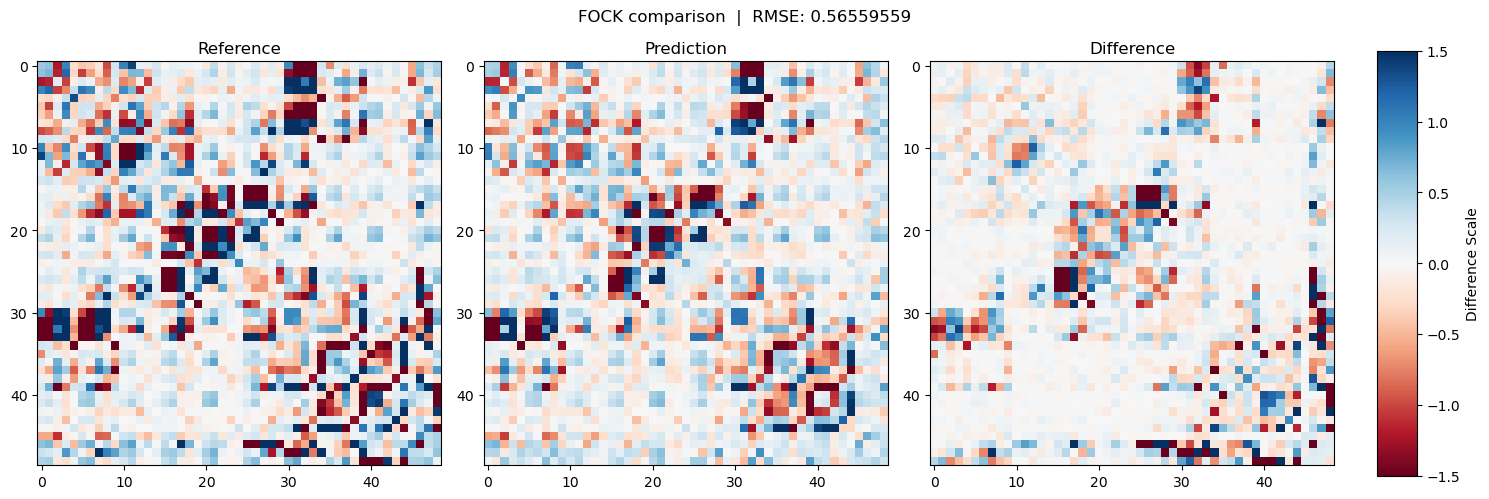

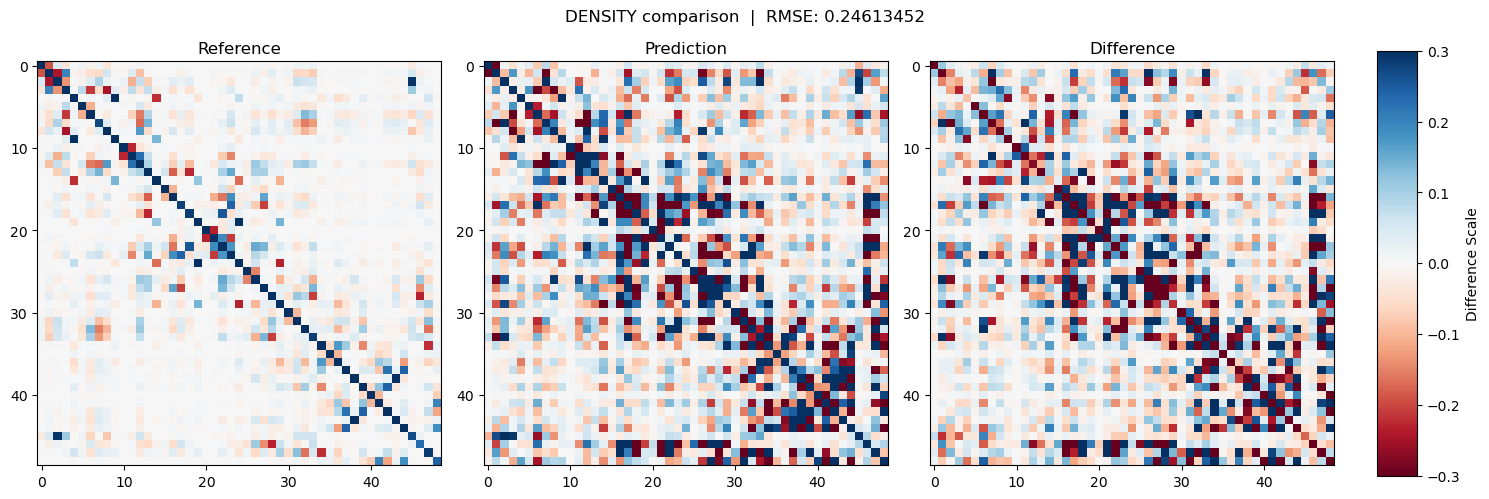

converged SCF energy = -446.849864095906
{'cycles': 31, 'conv': True, 'summary': {'nuc': np.float64(414.3948354964541), 'e1': np.float64(-1431.6303795577232), 'coul': np.float64(630.0353274602667), 'exc': np.float64(-59.64964749490306)}}


In [42]:
random_sample(basic_model_2)

# CNN 
Anscheinend kommt das MLP nicht gerade weit oder ich mach keine schönen Architekturen

In [75]:
# unflattened versions
flattened_sol_dim = train_y_scaled_flattened.shape[1]
train_X_scaled = unflatten_triang_batch(train_X_scaled_flattened, mat_dim)
test_X_scaled = unflatten_triang_batch(test_X_scaled_flattened, mat_dim)

# train_y_scaled = unflatten_triang_batch(train_y_scaled_flattened, mat_dim)
# test_y_scaled = unflatten_triang_batch(test_y_scaled_flattened, mat_dim)

In [76]:
tf.random.set_seed(42)
from tensorflow.keras import layers, Model, Input
dropout_rate = 0.5

inputs = Input(shape=(mat_dim, mat_dim, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(flattened_sol_dim)(x)

cnn_m1 = tf.keras.Model(inputs=inputs, outputs=outputs)

cnn_m1.compile(optimizer='adam', loss="mae", metrics=["mse", 'mae'])
cnn_m1.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 49, 49, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 49, 49, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 1225)           │       314,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,210,505 (8.43 MB)

 Trainable params: 2,210,505 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
cnn_m1_history = cnn_m1.fit(train_X_scaled, train_y_scaled_flattened, epochs=250, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/250


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.5859 - mae: 0.5859 - mse: 1.0066 - val_loss: 0.5436 - val_mae: 0.5436 - val_mse: 0.9410
Epoch 2/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5579 - mae: 0.5579 - mse: 1.0113 - val_loss: 0.5341 - val_mae: 0.5341 - val_mse: 0.9456
Epoch 3/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5465 - mae: 0.5465 - mse: 1.0168 - val_loss: 0.5254 - val_mae: 0.5254 - val_mse: 0.9555
Epoch 4/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5410 - mae: 0.5410 - mse: 1.0228 - val_loss: 0.5256 - val_mae: 0.5256 - val_mse: 0.9547
Epoch 5/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5389 - mae: 0.5389 - mse: 1.0245 - val_loss: 0.5229 - val_mae: 0.5229 - val_mse: 0.9601
Epoch 6/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5364 - mae: 0.5364 - mse: 1.0268 - val_loss: 0.5200 - val_mae: 0.5200 - val_mse: 0.9704
Epoch 7/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5352 - mae: 0.5352 - mse: 1.0309 - val_loss: 0.521

Text(0.5, 1.0, 'Model loss')

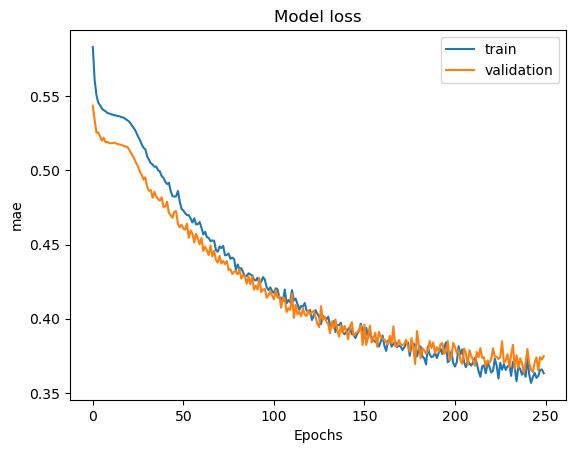

In [78]:
plt.plot(cnn_m1_history.history['loss'], label='train')
plt.plot(cnn_m1_history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


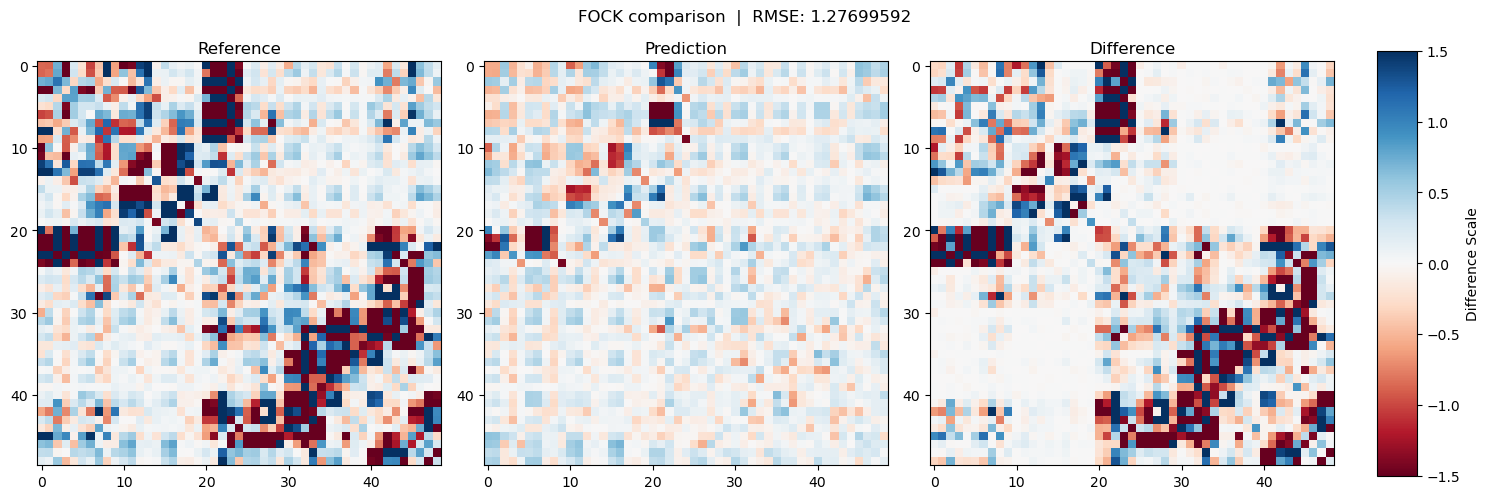

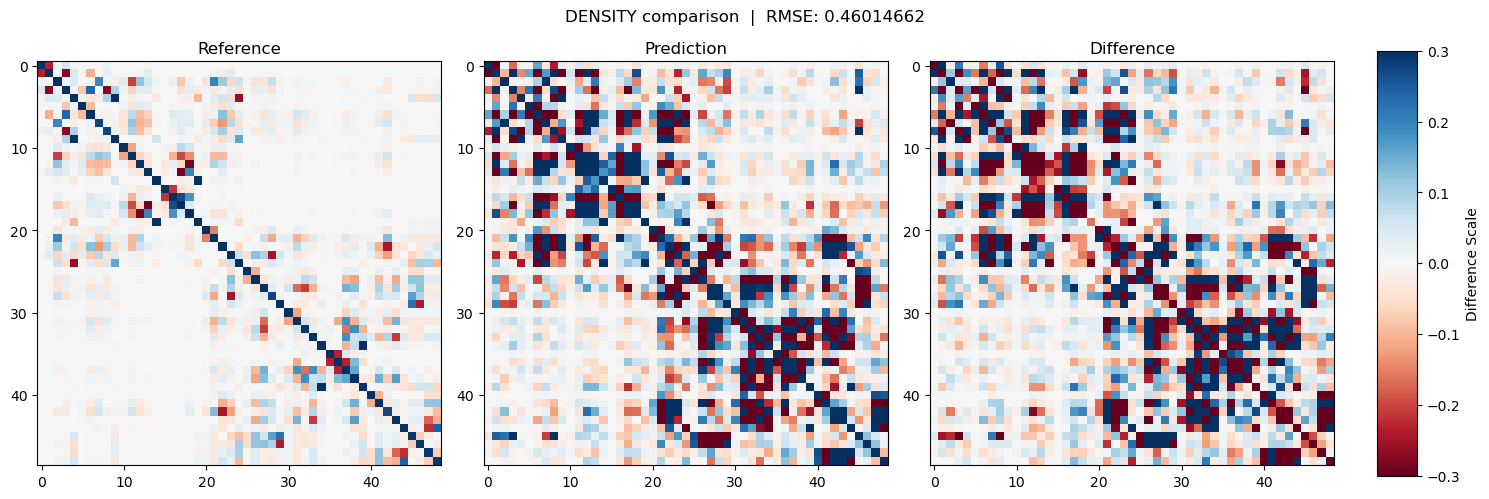

converged SCF energy = -446.877909260692
{'cycles': 23, 'conv': True, 'summary': {'nuc': np.float64(397.49408132293905), 'e1': np.float64(-1397.3108049940115), 'coul': np.float64(612.4978897496519), 'exc': np.float64(-59.55907533927143)}}


In [81]:
random_sample(cnn_m1, flat_input=False)